In [9]:
import pandas as pd
from pandas.io import gbq

pd.set_option('display.max_column',40)

In [10]:
PROJECT_ID='your_project_id'
train_tables = ["train_activity", "train_guild", "train_label", "train_party", "train_payment", "train_trade"]
test_tables = ["test_activity", "test_guild", "test_party", "test_payment", "test_trade"]

In [11]:
def query_from_bigquery(query):
    df = gbq.read_gbq(query = query, project_id=PROJECT_ID, dialect='standard', 
                      verbose=False, configuration = {'query': {'useQueryCache': True}})
    return df

## Feature Engineering
### 가설
- 1) 결제한 유저들은 게임을 더 오래할 것이다
    - 생성 feature : payment_cnt, payment_total
- 2) 문파에 가입한 유저들은 게임을 더 오래할 것이다(단, 길드의 멤버수도 영향을 끼칠 것이다)
    - 생성 feature : guild_tf, guild_member_cnt
    - guild는 9963개.. 우선은 guild 가입 유무 변수만 추가
- 3) 접속하는 빈도를 통해 속도를 측정할 수 있을 것이다(소수점 둘째자리에서 round)
    - 생성 feature : login_speed : sum(cnt_dt)/count(wk)\*7, last_week : max(wk)
    - 1주차 7일, 2주차 7일, 3주차 7일 => feature 1. 접속 속도 1, max(접속주차) => feature2. 마지막 주차
    - 1주차 7일, 2주차 5일 = 12/14 = 0.85
    - 1주차 7일, 3주차 3일 = 10/21 = 0.47
    - sum(cnt_dt)/count(wk)\*7
- 4) Baseline에는 activity에서 다음만 사용 : wk, cnt_dt, play_time, normal_chat, cnt_use_buffitem

### 각 가설 추출하는 쿼리
- 결제한 유저들은 게임을 더 오래할 것이다

In [16]:
%%time
query = '''
        select acc_id, count(acc_id) as payment_cnt, sum(payment_amount) as payment_total
        from `nc_new.train_payment` 
        group by acc_id
        '''

payment_df = query_from_bigquery(query)
payment_df

CPU times: user 2.24 s, sys: 83.9 ms, total: 2.33 s
Wall time: 9.67 s


- 문파에 가입한 유저들은 게임을 더 오래할 것이다(단, 길드의 멤버수도 영향을 끼칠 것이다)

In [17]:
%%time
query = '''
        select guild_member, "True" as guild_tf, guild_member_cnt
        from(
        select string_field_0 as guild, guild_member, array_length(split(string_field_1)) as guild_member_cnt
        from `nc_new.train_guild`, UNNEST(split(string_field_1)) as guild_member
        )
'''

guild_df = query_from_bigquery(query)
guild_df

CPU times: user 1.18 s, sys: 24.4 ms, total: 1.2 s
Wall time: 5.79 s


- 3) 접속하는 빈도를 통해 속도를 측정할 수 있을 것이다 
    - 생성 feature : login_speed : sum(cnt_dt)/count(wk)\*7, last_week : max(wk)
- 4) wk, cnt_dt, play_time, normal_chat, cnt_use_buffitem
    - 소수점 모두 2자리에서 round

In [ ]:
query = '''
        select acc_id, ROUND(sum(cnt_dt)/(count(wk)*7), 2) as login_speed, max(wk) as last_week,
        count(wk) as wk_cnt, sum(cnt_dt) total_dt, sum(play_time) as total_play_time, sum(normal_chat) as total_normal_chat, MAX(cnt_use_buffitem) as use_buffitem
        from `nc_new.train_activity` 
        group by acc_id
        '''

## Join Query

In [46]:
query = '''
        select a.acc_id, a.login_speed, a.last_week, a.wk_cnt, a.total_dt, a.total_play_time, a.total_normal_chat, a.use_buffitem,
              b.label, c.payment_cnt, c.payment_total, max(d.guild_tf) as guild_tf, max(d.guild_member_cnt) as guild_member_cnt
        from 
          (select acc_id, ROUND(sum(cnt_dt)/(count(wk)*7), 2) as login_speed, max(wk) as last_week, count(wk) as wk_cnt, 
          sum(cnt_dt) total_dt, sum(play_time) as total_play_time, sum(normal_chat) as total_normal_chat, MAX(cnt_use_buffitem) as use_buffitem
          from `nc_new.train_activity` 
          group by acc_id) as a
        left join 
          (select string_field_0 as id, string_field_1 as label from `nc_new.train_label`) as b on a.acc_id = b.id
        left join 
          (select acc_id, count(acc_id) as payment_cnt, sum(payment_amount) as payment_total from `nc_new.train_payment`  group by acc_id) as c USING(acc_id)
        left join 
          (select guild_member, 1 as guild_tf, guild_member_cnt 
          from
            (select string_field_0 as guild, guild_member, array_length(split(string_field_1)) as guild_member_cnt
              from `nc_new.train_guild`, UNNEST(split(string_field_1)) as guild_member)) as d on a.acc_id = d.guild_member
        group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
        '''

In [47]:
%%time
train_df = query_from_bigquery(query)
train_df

CPU times: user 5.59 s, sys: 281 ms, total: 5.87 s
Wall time: 21.6 s


In [77]:
train_df.head()

In [49]:
train_df['label'].value_counts()

2month      25000
month       25000
retained    25000
week        25000
Name: label, dtype: int64

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


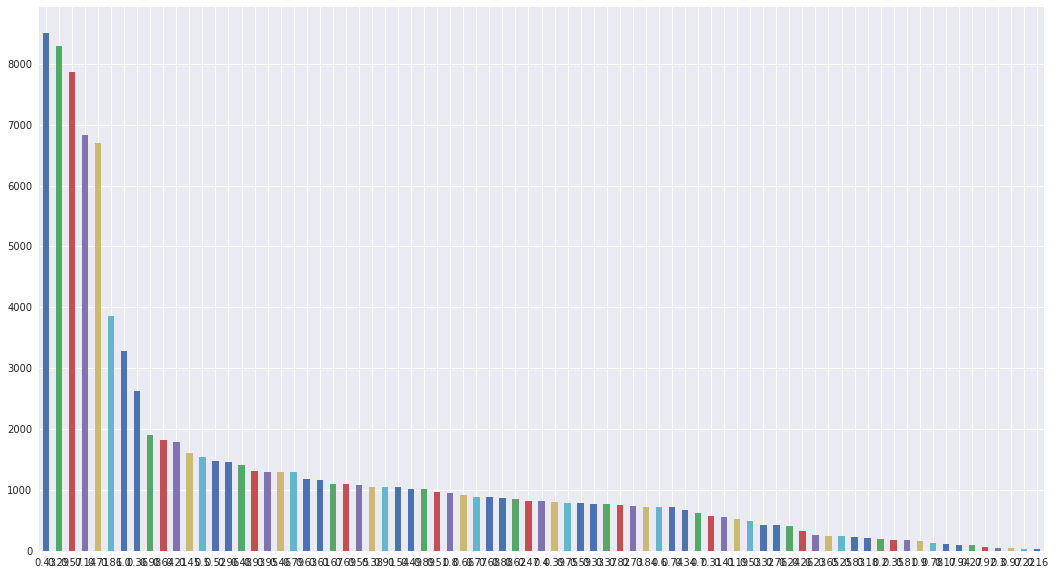

In [50]:
train_df['login_speed'].value_counts().plot(kind='bar', rot=0, figsize=(18,10))

In [72]:
train_df['guild_tf'].value_counts()

In [73]:
train_df['guild_member_cnt'].value_counts().head()

In [59]:
train_df.fillna(value=0, inplace=True)

In [74]:
train_df['guild_tf'].value_counts()

In [75]:
train_df.head()

In [64]:
train_df.to_csv("train.csv")

# Test DF 부분

In [65]:
test_query = '''
        select a.acc_id, a.login_speed, a.last_week, a.wk_cnt, a.total_dt, a.total_play_time, a.total_normal_chat, a.use_buffitem,
            c.payment_cnt, c.payment_total, max(d.guild_tf) as guild_tf, max(d.guild_member_cnt) as guild_member_cnt
        from 
          (select acc_id, ROUND(sum(cnt_dt)/(count(wk)*7), 2) as login_speed, max(wk) as last_week, count(wk) as wk_cnt, 
          sum(cnt_dt) total_dt, sum(play_time) as total_play_time, sum(normal_chat) as total_normal_chat, MAX(cnt_use_buffitem) as use_buffitem
          from `nc_new.test_activity` 
          group by acc_id) as a
        left join 
          (select acc_id, count(acc_id) as payment_cnt, sum(payment_amount) as payment_total from `nc_new.test_payment`  group by acc_id) as c USING(acc_id)
        left join 
          (select guild_member, 1 as guild_tf, guild_member_cnt 
          from
            (select string_field_0 as guild, guild_member, array_length(split(string_field_1)) as guild_member_cnt
              from `nc_new.test_guild`, UNNEST(split(string_field_1)) as guild_member)) as d on a.acc_id = d.guild_member
        group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
        '''

In [66]:
%%time
test_df = query_from_bigquery(test_query)

CPU times: user 2.24 s, sys: 17.4 ms, total: 2.25 s
Wall time: 9.1 s


In [67]:
test_df.fillna(value=0, inplace=True)

In [76]:
test_df.tail()

In [71]:
test_df.to_csv("test.csv")